# Clustering


In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns
from pyclustertend import hopkins, vat

#### _1.1 Haga el preprocesamiento del dataset, explique qué variables no aportan información a la generación de grupos y por qué. Describa con qué variables calculará los grupos_


<small>

**Variables que no aportan información para clústering:**

Es importante resaltar que clustering se maneja por medio de valores numéricos. Por lo tanto, los valores que no aportan información para clústering son:

1. **id:** Es solo el identificador único, no tiene relevancia para la agrupación.
2. **homepage:** Debido a que es una URL, no aporta valor numérico o categórico relevante.
3. **originalTile y title:** Es el nombre de las películas, no aportan información cuantificable.
4. **originalLanguage:** Es una variable categórica con demasiadas clases, no es relevante para el clústering.
5. **releaseDate:** Es una fecha que no aporta información numérica útil directamente.
6. **director, actor, actorsCharacter:** Son nombres de personas, no datos útiles para análisis cuantitativo.
7. **video:** Contiene valores _True/False_, lo cual no es tan útil para el clustering en este caso.
8. **productionCompany, productionCompanyCountry, productionCountry, genres:** Su formato textual dificulta el uso de clustering.

</small>


<small>

**Variables Seleccionadas para Calcular los Grupos**

Cabe resaltar que todas las variables seleccionadas para calcular grupos, son de tipo cuantitativo.

1. budget
2. revenue
3. popularity
4. voteAvg
5. voteCount
6. runtime
7. genresAmount
8. productionCoAmount
9. productionCountriesAmount
10. actosPopularity
11. actorsAmount
12. castWomenAmount
13. castMenAmount
    </small>


### Análisis de agrupamientos de datos realizados


<small>

#### **Variables de rendimiento financiero**

1. Budget
2. Revenue
3. Popularity
4. VoteAvg
5. VoteCount

**Razón de agrupamiento:** Estas variables están relacionadas con el desempeño económico y la recepción del público. Las películas con un presupuesto elevado podría esperar una mayor recaudación y la popularidad o promedio de votos puede ayudar a identificar patrones de éxito o fracaso. Al agruparlas, se puede detectar si existe un segmento de películas con alta inversión y alta recaudación vs otro con baja inversión y bajo rendimiento.

#### **Variables de producción, diversidad y tiempo**

1. GenresAmount
2. ProductionCoAmount
3. ProductionCountriesAmount
4. Runtime

**Razón de agrupamiento:** Estas variables reflejan la diversidad, complejidad del proceso productivo y el tiempo total del resultado. Por ejemplo, se pueden tener películas con múltiples géneros que involucran varias compañías y países que pueden tener estrategias de marketing o distribución muy distintas a aquellas producidas de forma más limitada. Por lo que puede influir en la percepción del público, rendimiento económico, etc.

#### **Variables relacionadas con el elenco**

1. actosPopularity_avg
2. actorsAmount
3. castWomenAmount y castMenAmount

**Razón de agrupamiento:** El potencial comercial del elenco es un factor importante en la industria del cine. Un reparto con actores reconocidos o con alta popularidad puede atraer a una audiencia mayor, lo cual podría relacionarse con mejores resultados en taquilla y recepción crítica. Además, el balance entre cast femenino y masculino puede ser interesante para identificar tendencias en ciertos géneros o estilos de producción.

</small>


#### _1.2 Analice la tendencia al agrupamiento usando el estadístico de Hopkings y la VAT (Visual Assessment of cluster Tendency). Esta última hágala si es posible, teniendo en cuenta las dimensiones del conjunto de datos. Discuta sus resultados e impresiones._


In [6]:
file_path = "movies.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Preprocesar 'actorsPopularity' para calcular el promedio de popularidades
def calculate_mean_popularity(popularity_string):
    try:
        popularity_values = list(map(float, popularity_string.split('|')))
        if len(popularity_values) > 0:
            return np.mean(popularity_values)
        else:
            return 0
    except:
        return 0

df['actorsPopularity'] = df['actorsPopularity'].apply(calculate_mean_popularity)

# Variables seleccionadas para clustering
features = [
    "budget", "revenue", "runtime", "actorsPopularity",
    "popularity", "voteAvg", "voteCount", "genresAmount",
    "productionCoAmount", "productionCountriesAmount",
    "actorsAmount", "castWomenAmount", "castMenAmount"
]

# Filtrar solo las columnas relevantes
df_cluster = df[features].copy()

# Convertir castWomenAmount y castMenAmount a numérico (por si tienen strings)
df_cluster["castWomenAmount"] = pd.to_numeric(df_cluster["castWomenAmount"], errors="coerce")
df_cluster["castMenAmount"] = pd.to_numeric(df_cluster["castMenAmount"], errors="coerce")

# Manejo de valores nulos con la mediana
df_cluster[df_cluster.select_dtypes(include=[np.number]).columns] = df_cluster.select_dtypes(include=[np.number]).fillna(df_cluster.median(numeric_only=True))

# Normalizar los datos para clustering
df_scaled = scale(df_cluster)  

# Calcular el estadístico de Hopkins usando pyclustertend
hopkins_score = hopkins(df_scaled, df_scaled.shape[0])
print(f"Estadístico de Hopkins: {hopkins_score:.4f}")

# Visual Assessment of Cluster Tendency (VAT) usando pyclustertend
if df_scaled.shape[0] <= 5000:  # Verificar el tamaño para evitar problemas de visualización
    vat(df_scaled)
else:
    print("VAT omitida por el tamaño de los datos.")

Estadístico de Hopkins: 0.0176
VAT omitida por el tamaño de los datos.


<small>

### **Análisis de Hopkins**

El resultado obtenido del estadístico de Hopkins fue de **0.0176**, lo cual es significativamente bajo y sugiere una alta propensión al agrupamiento dentro del conjunto de datos analizado. En el contexto de la minería de datos, un valor de Hopkins tan bajo es indicativo de que los datos no están distribuidos de manera aleatoria y, por lo tanto, existen patrones intrínsecos que pueden ser identificados mediante técnicas de clustering.

### **Análisis de VAT**

La omisión de la Visual Assessment of Cluster Tendency (VAT) se debió al tamaño considerable del dataset, que plantea desafíos computacionales y de visualización. La técnica VAT es una herramienta útil para evaluar visualmente si un conjunto de datos contiene grupos naturales discernibles, pero su eficacia disminuye con el aumento del tamaño del dataset debido a la complejidad de la representación visual de las distancias entre datos en una matriz de disimilitud.
</small>


#### _1.3 Determine cuál es el número de grupos a formar más adecuado para los datos que está trabajando. Haga una gráfica de codo y explique la razón de la elección de la cantidad de clústeres con la que trabajará._


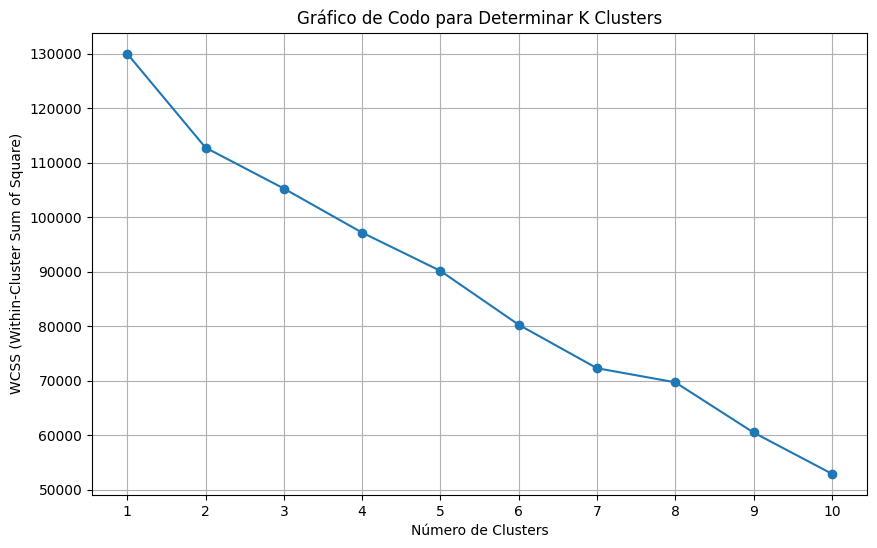

In [3]:
# Cargar tus datos
file_path = "movies.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Preprocesar los datos, asegurándote de que solo incluyas las columnas numéricas relevantes
features = [
    "budget", "revenue", "runtime", "actorsPopularity",
    "popularity", "voteAvg", "voteCount", "genresAmount",
    "productionCoAmount", "productionCountriesAmount",
    "actorsAmount", "castWomenAmount", "castMenAmount"
]
df_cluster = df[features]

# Convertir y manejar valores no numéricos o faltantes
df_cluster = df_cluster.apply(pd.to_numeric, errors='coerce')
df_cluster.fillna(df_cluster.mean(), inplace=True)

# Normalización de los datos usando scale
X_scale = scale(df_cluster)  

# Determinación del número de clusters mediante el Gráfico de Codo
numeroClusters = range(1, 11)
wcss = []

for i in numeroClusters:
    kmeans = KMeans(n_clusters=i) 
    kmeans.fit(X_scale)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(numeroClusters, wcss, marker='o')
plt.xticks(numeroClusters)
plt.xlabel("Número de Clusters")
plt.ylabel("WCSS (Within-Cluster Sum of Square)")
plt.title("Gráfico de Codo para Determinar K Clusters")
plt.grid(True)
plt.show()

<small>

</small>


<small>

### Análisis de gráfica de codo

El gráfico de codo presentado no revela un punto claro de inflexión que indique el número óptimo de clusters. La ausencia de un "codo" pronunciado sugiere que no hay una reducción significativa en la variación dentro de los clusters más allá de cada incremento en el número de clusters. Esta tendencia indica que los datos pueden ser demasiado complejos o heterogéneos para ser adecuadamente capturados por el método de K-means, que depende de la suposición de que los clusters son esferoidales y relativamente uniformes en tamaño.

Dada la disminución continua y gradual del WCSS, que no se estabiliza claramente con un número mayor de clusters, se propone explorar otras técnicas de clustering más adecuadas para los datos en cuestión. Métodos como DBSCAN o clustering jerárquico son alternativas viables porque no requieren la especificación previa del número de clusters y son capaces de identificar clusters basados en densidad o jerarquía, respectivamente. Estos métodos podrían ofrecer un enfoque más flexible y ajustado a la naturaleza de los datos analizados.
</small>


#### _1.4 Utilice los algoritmos k-medias y clustering jerárquico para agrupar. Compare los resultados generados por cada uno._


#### Cálculo k-medias


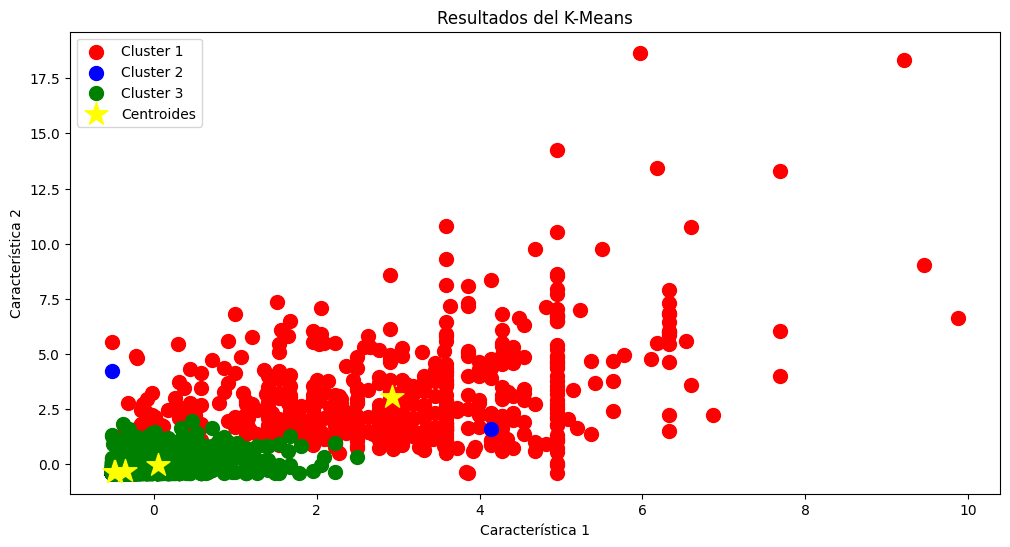

In [15]:
# Asumiendo que X_scale es tu dataset normalizado
km = KMeans(n_clusters=5, random_state=42)
especies_km = km.fit_predict(X_scale)

# Centroides de los clusters
centroides = km.cluster_centers_

# Visualización de los resultados de K-Means
plt.figure(figsize=(12, 6))
plt.scatter(X_scale[especies_km == 0, 0], X_scale[especies_km == 0, 1], s=100, c='red', label="Cluster 1")
plt.scatter(X_scale[especies_km == 1, 0], X_scale[especies_km == 1, 1], s=100, c='blue', label="Cluster 2")
plt.scatter(X_scale[especies_km == 2, 0], X_scale[especies_km == 2, 1], s=100, c='green', label="Cluster 3")
plt.scatter(centroides[:, 0], centroides[:, 1], s=300, c="yellow", marker="*", label="Centroides")
plt.title("Resultados del K-Means")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.legend()
plt.show()

#### Cálculo Clústering Jerárquico


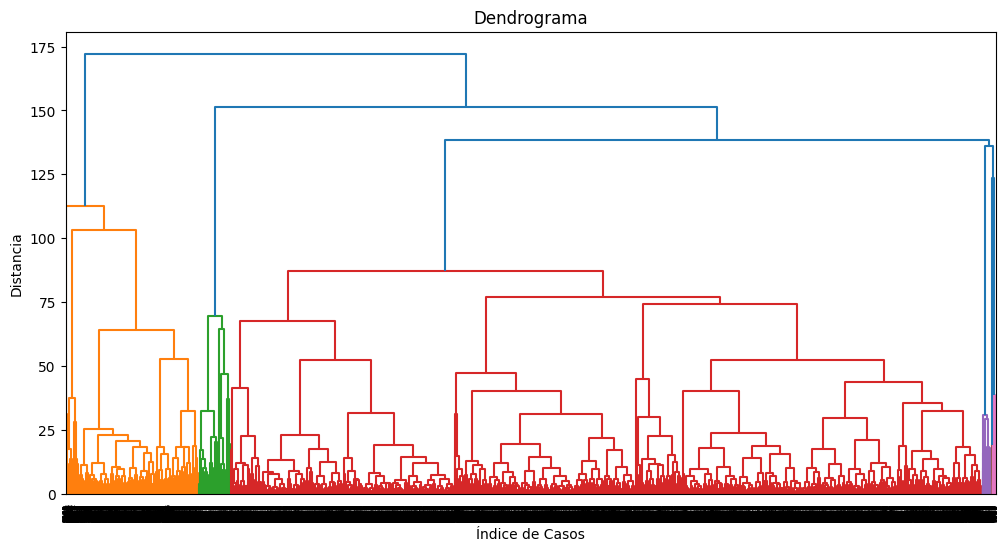

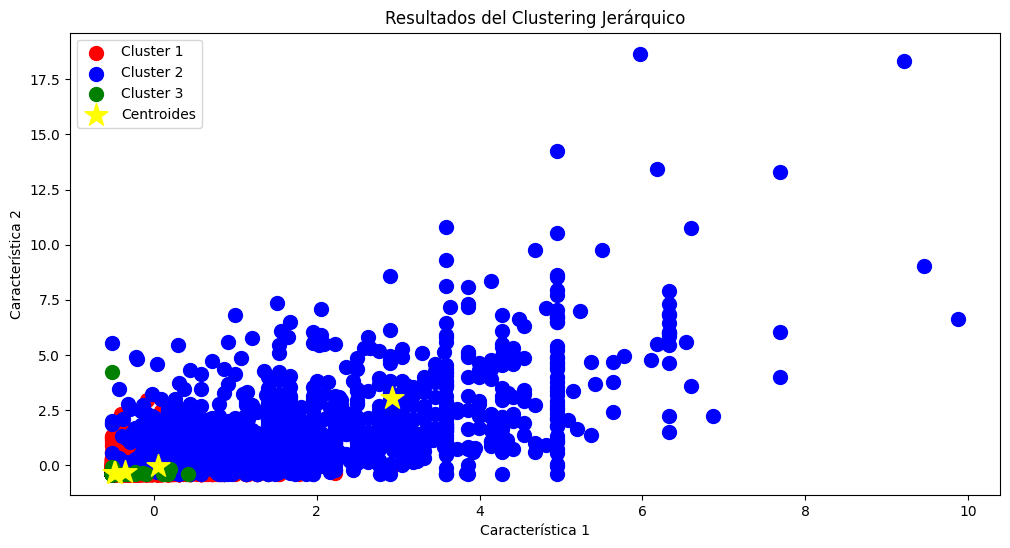

In [16]:
# Dendrograma para visualizar la estructura de clustering jerárquico
plt.figure(figsize=(12, 6))
dendrograma = sch.dendrogram(sch.linkage(X_scale, method='ward'))
plt.title("Dendrograma")
plt.xlabel("Índice de Casos")
plt.ylabel("Distancia")
plt.show()

# Clustering Jerárquico
hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
especies_hc = hc.fit_predict(X_scale)

# Visualización de los resultados del Clustering Jerárquico
plt.figure(figsize=(12, 6))
plt.scatter(X_scale[especies_hc == 0, 0], X_scale[especies_hc == 0, 1], s=100, c='red', label="Cluster 1")
plt.scatter(X_scale[especies_hc == 1, 0], X_scale[especies_hc == 1, 1], s=100, c='blue', label="Cluster 2")
plt.scatter(X_scale[especies_hc == 2, 0], X_scale[especies_hc == 2, 1], s=100, c='green', label="Cluster 3")
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1], s=300, c="yellow",marker="*", label="Centroides")
plt.title("Resultados del Clustering Jerárquico")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.legend()
plt.show()